## Cài đặt và chuẩn bị dữ liệu

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import os  
import cv2  
import zipfile  
import random  
import albumentations  
import subprocess
from PIL import Image

from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score 
from joblib import dump
from IPython.display import FileLink, display 

from keras.src.legacy.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2  # Import MobileNetV2 model from keras for transfer learning
from tensorflow.keras.models import Model  # Import Model class from keras for defining custom neural network architectures
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input  # Import layers from keras for building neural networks
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer from keras for model optimization
from keras.utils import plot_model  # Import plot_model function from keras for visualizing model architectures
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping  # Import callbacks from keras for adjusting learning rate and early stopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenetv2_preprocess_input  # Import preprocess_input function from keras for MobileNetV2 models
from tensorflow.keras.models import load_model  # Import load_model function from keras for loading pre-trained models


2024-05-29 13:39:39.041557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 13:39:39.041623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 13:39:39.043070: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


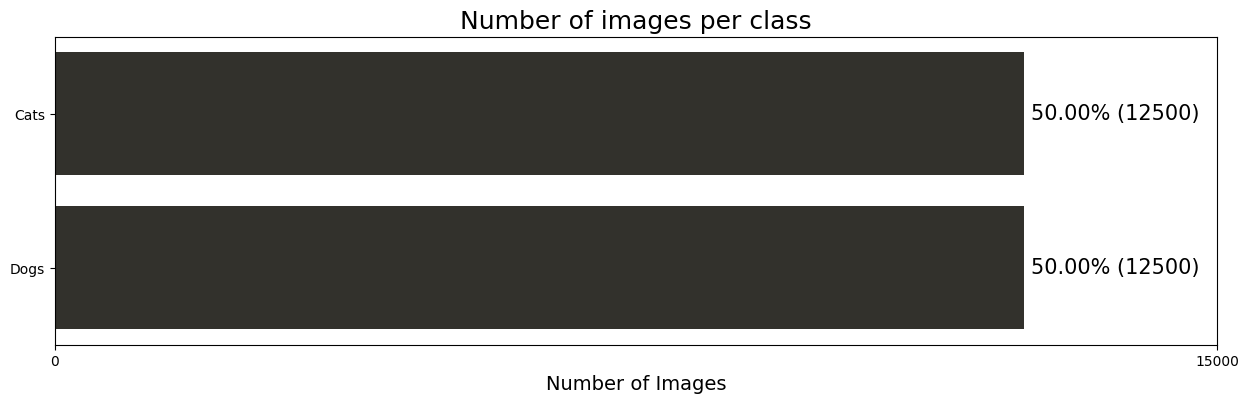

In [2]:
# Specify the path to the zip file
zip_path = '/kaggle/input/dogs-vs-cats/train.zip'
extract_path = '/kaggle/working/'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# After extracting, specify the directory of the actual images
actual_extracted_path = os.path.join(extract_path, 'train')

# List all filenames in the actual extracted directory
filenames = os.listdir(actual_extracted_path)

# Separate filenames into cats and dogs
cat_images = [filename for filename in filenames if "cat" in filename]
dog_images = [filename for filename in filenames if "dog" in filename]

# Get the count of each class
cat_count = len(cat_images)
dog_count = len(dog_images)

# Calculate the percentages
total_images = cat_count + dog_count
cat_percentage = (cat_count / total_images) * 100
dog_percentage = (dog_count / total_images) * 100

# Plotting
labels = ['Cats', 'Dogs']
counts = [cat_count, dog_count]
percentages = [cat_percentage, dog_percentage]

# Set the figure size
plt.figure(figsize=(15, 4))

# Create a horizontal bar plot
ax = sns.barplot(y=labels, x=counts, orient='h', color='#33312b')
ax.set_xticks([0, 15000])

# Annotate each bar with the count and percentage
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 100, p.get_y() + p.get_height()/2., 
            '{:1.2f}% ({})'.format(percentages[i], counts[i]),
            va="center", fontsize=15)
    
# Set the x-label for the plot
plt.xlabel('Number of Images', fontsize=14)
plt.title("Number of images per class", fontsize=18)
plt.show()


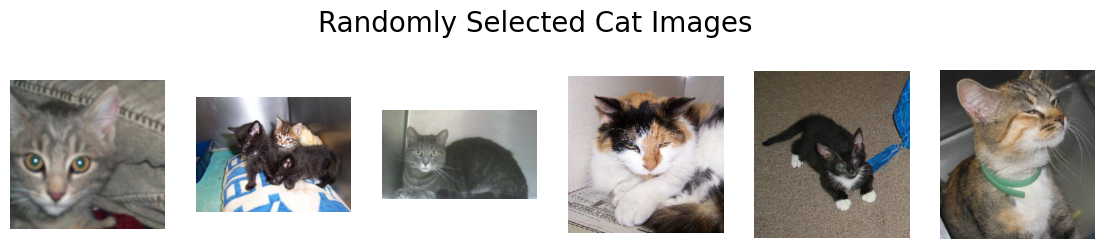

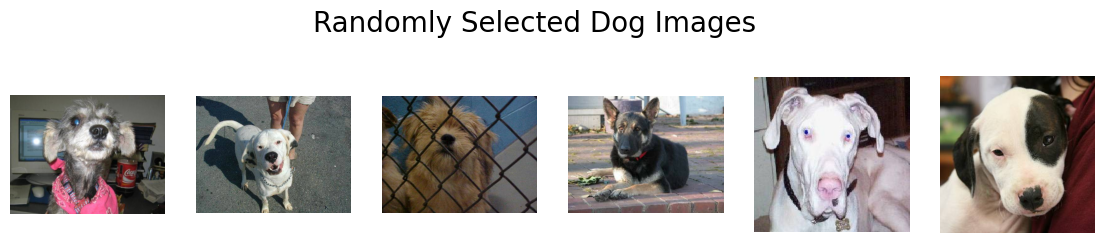

In [3]:
np.random.seed(42)
random_cat_images = np.random.choice(cat_images, 6)  
random_dog_images = np.random.choice(dog_images, 6) 

# Function to plot images
def plot_images(images, title):
    plt.figure(figsize=(14, 3)) 
    for i, img_name in enumerate(images):
        plt.subplot(1, 6, i+1)
        img = cv2.imread(os.path.join(actual_extracted_path, img_name)) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        plt.imshow(img) 
        plt.axis('off') 
    plt.suptitle(title, fontsize=20) 
    plt.show() 

# Plot the images
plot_images(random_cat_images, "Randomly Selected Cat Images")  
plot_images(random_dog_images, "Randomly Selected Dog Images") 


In [4]:
data = []

# Append the cat image file paths with label "cat" to the data list
data.extend([(os.path.join(actual_extracted_path, filename), "cat") for filename in cat_images])

# Append the dog image file paths with label "dog" to the data list
data.extend([(os.path.join(actual_extracted_path, filename), "dog") for filename in dog_images])

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

del data, cat_images, dog_images

## Phân tích và tách dữ liệu

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print("Training data shape:", train_df.shape)
print("test data shape:", test_df.shape)

del df

Training data shape: (20000, 2)
test data shape: (5000, 2)


In [6]:
# Sử dụng PCA để giảm chiều dữ liệu
def reduce_dimensionality(features, n_components=0.90, fit_pca=None):
    if fit_pca is None:
        pca = PCA(n_components=n_components, random_state = 42)
        reduced_features = pca.fit_transform(features)
        return reduced_features, pca
    else:
        reduced_features = fit_pca.transform(features)
        return reduced_features

### MobileNetV2 

In [7]:
#Hàm này trả về Keras image classification model, được tối ưu hóa các trọng số bằng cách pre-trained trên bộ dữ liệu ImageNet.
mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#mobilenetv2_base.summary()

# Sử dụng GlobalAveragePooling layer để giảm feature maps thành một vector tương ứng mới mỗi map
gap = GlobalAveragePooling2D()(mobilenetv2_base.output)

# Construct the feature extractor model
mobilenetv2_feature_extractor = Model(inputs=mobilenetv2_base.input, outputs=gap)

output_shape = mobilenetv2_feature_extractor.output_shape
print("Output shape of feature extractor model:", output_shape)

Output shape of feature extractor model: (None, 1280)


In [8]:
mobilenetv2_base.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [9]:
def create_feature_extraction_generator(preprocessing_function, dataframe, x_col, y_col, batch_size=32, image_dimensions=(224, 224)):    
    # Initialize the ImageDataGenerator with the preprocessing function
    datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)
    
    # Create the generator to read images from the dataframe
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,         
        x_col=x_col,                  
        y_col=y_col,                  
        target_size=image_dimensions, 
        batch_size=batch_size,      
        class_mode='binary',         
        shuffle=False                
    )  
    return generator

def extract_features(model, generator):
    features = model.predict(generator, steps=len(generator), verbose=1)
    labels = generator.classes
    
    return features, labels

In [10]:
train_generator = create_feature_extraction_generator(mobilenetv2_preprocess_input, train_df, "filepath", "label", 32, (224, 224))
test_generator = create_feature_extraction_generator(mobilenetv2_preprocess_input, test_df, "filepath", "label", 32, (224, 224))
    
# Extract features from the generators using the feature extractor model
train_features, train_labels = extract_features(mobilenetv2_feature_extractor, train_generator)
test_features, test_labels = extract_features(mobilenetv2_feature_extractor, test_generator)
    
# Reduce the dimensionality of the training features and get the fitted PCA
train_features, pca = reduce_dimensionality(train_features, n_components=0.90)
test_features= reduce_dimensionality(test_features, fit_pca=pca)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
  4/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step

I0000 00:00:1716989999.732337     408 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step


## SVM


In [11]:
from sklearn.svm import SVC

In [12]:
def train_svm(features, labels, kernel):
    svm = SVC(kernel = kernel, C = 10, max_iter = 50000)  
    svm.fit(features, labels)
    return svm

def draw_barplot(accuracies):
    # Convert the dictionary into a pandas DataFrame for easy plotting
    accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])

    # Create a horizontal bar plot
    plt.figure(figsize=(15, 6))
    bar_plot = sns.barplot(x='Accuracy', y='Model', data=accuracy_df, orient='h')

    # Add the accuracy values on the bars
    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_width(), '.3%'), 
                          (p.get_width()+0.02, p.get_y() + p.get_height() / 2),
                          ha='center', va='center',
                          xytext=(5, 0), textcoords='offset points', fontsize=15)

    plt.xlabel('Accuracy')
    plt.title('Accuracy Assessment of Models')
    plt.xlim(0, 1.1)  
    plt.tight_layout()
    plt.show()

In [13]:
kernel = ["linear", "poly", "rbf"]
dict0 = {}
dict_model_SVM = {}

In [14]:
for k in kernel:
    modelSVM_MobileNetV2 = train_svm(train_features, train_labels, k)
    accuracySVM_MobileNetV2 = accuracy_score(test_labels, modelSVM_MobileNetV2.predict(test_features))
    s = "modelSVM_MobileNetv2 " + k
    dict0[s] = accuracySVM_MobileNetV2 
    dict_model_SVM[s] = modelSVM_MobileNetV2

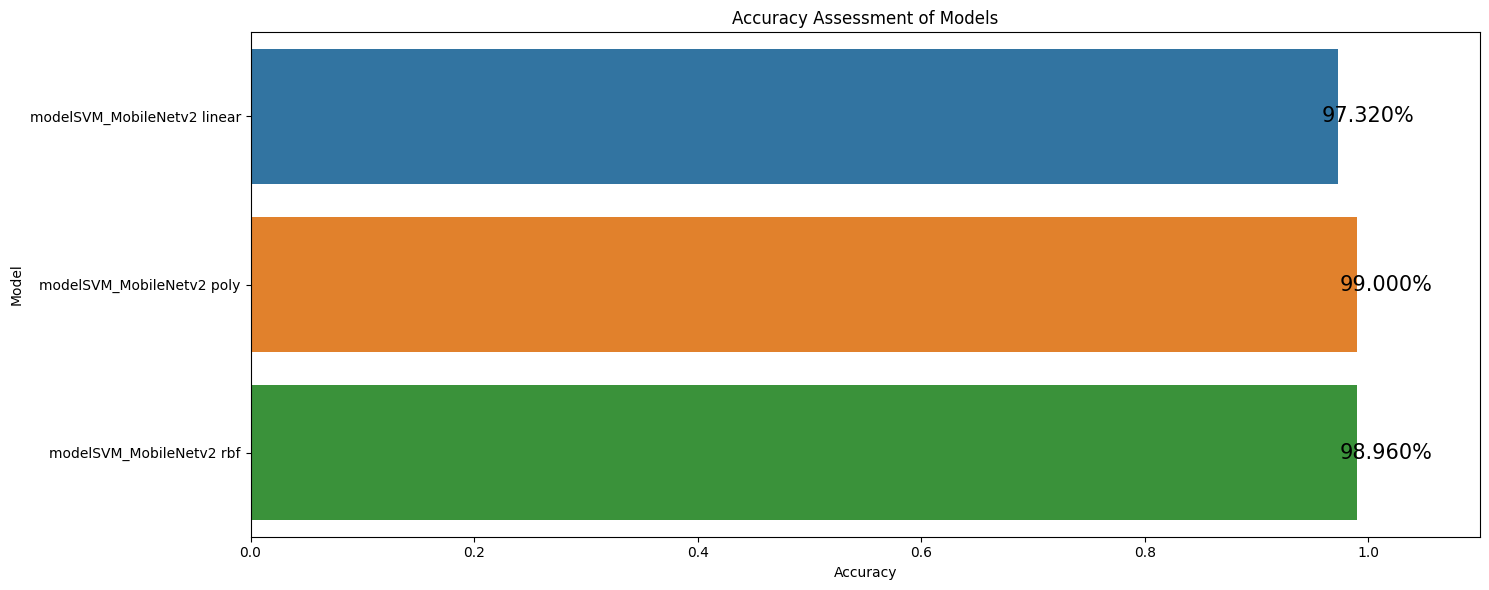

In [15]:
draw_barplot(dict0)

## Deployment

In [16]:
mobilenetv2_feature_extractor.save('mobilenetv2_feature_extractor.h5')
# Save the PCA transformer, which is used to reduce the dimensionality of the features from the MobileNetV2 feature extractor
dump(pca, 'pca_transformer.joblib')
dump(dict_model_SVM['modelSVM_MobileNetv2 rbf'], 'SVM.joblib')

['SVM.joblib']